In [2]:
import numpy as np

In [3]:
# loading data

In [4]:
x_all = np.load('x_sigs.npy')
fx = np.load('features.npy')
y_mc = np.load('y_mc.npy')

In [5]:
# binary class labels
y_b = np.copy(y_mc)
y_b[y_b<=1] = 0
y_b[y_b>=2] = 1

In [6]:
# 0-1 -> normal ECG
# 2-16 -> anomaly

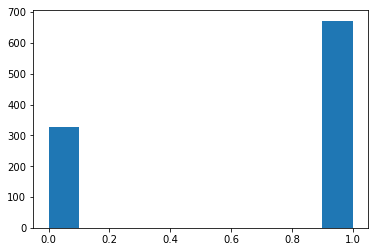

In [7]:
import matplotlib.pyplot as plt
plt.hist(y_b)
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fx)
print(scaler.mean_)
fx = scaler.transform(fx)

print(np.mean(fx))
print(np.std(fx))

[3.4163018e+09 5.3098379e+04 1.9286356e+03 2.8326578e+04 1.4957513e-01
 2.2935305e+00 1.5088350e+00 1.8876824e+06 2.2846521e+04 3.1334696e+01]
1.0986328e-07
0.99999994


In [9]:
x_all.shape

(1000, 905)

In [10]:
scaler = StandardScaler()
scaler.fit(x_all)
print(scaler.mean_)
x_all = scaler.transform(x_all)

print(np.mean(x_all))
print(np.std(x_all))

[1939.5435 1939.7426 1939.4132 1939.6099 1939.8888 1938.5876 1935.9607
 1935.033  1933.0187 1929.4152 1927.6764 1927.1282 1924.5441 1928.1434
 1932.6597 1935.5975 1940.7992 1940.5189 1938.0455 1938.1248 1942.8406
 1948.7866 1948.5162 1944.9203 1942.4865 1942.1248 1939.8838 1935.405
 1934.4564 1930.1993 1929.1168 1935.671  1940.3977 1938.3549 1937.1805
 1936.7863 1932.7354 1931.3853 1934.1587 1934.88   1934.7776 1937.382
 1940.5823 1942.846  1947.0247 1945.3303 1937.2406 1931.9583 1927.4333
 1926.7278 1929.728  1935.8071 1939.8489 1939.0819 1936.4929 1936.2495
 1934.8951 1932.2361 1932.0349 1931.3812 1930.2816 1929.3276 1932.3474
 1937.6652 1938.4252 1934.038  1927.25   1921.6204 1916.2822 1921.0366
 1928.8647 1927.1609 1921.2809 1922.6769 1927.9186 1929.7268 1930.3861
 1933.2346 1935.9164 1937.472  1940.6082 1936.9957 1935.3398 1938.4211
 1933.6128 1930.3027 1932.0123 1932.0458 1933.0117 1928.4961 1924.449
 1928.3372 1930.7655 1931.9359 1936.3656 1939.032  1940.1161 1936.8181
 1934.116

In [11]:
x_all.shape

(1000, 905)

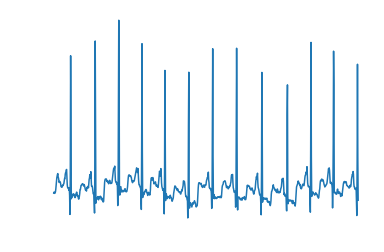

In [12]:
plt.plot(x_all[5])
plt.axis('off')
plt.savefig('ecg_input.png', dpi = 1000)
plt.show()

In [13]:
# train, test  == stratified
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(fx, y_b)

print(sss)       

for train_index, test_index in sss.split(fx, y_b):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xs_train, Xf_train, Xs_test, Xf_test = x_all[train_index], fx[train_index], x_all[test_index], fx[test_index]
    y_train, y_test = y_b[train_index], y_b[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


In [14]:
print(Xs_train.shape)
print(Xf_train.shape)
print(Xs_test.shape)
print(Xf_test.shape)

(800, 905)
(800, 10)
(200, 905)
(200, 10)


(200,)


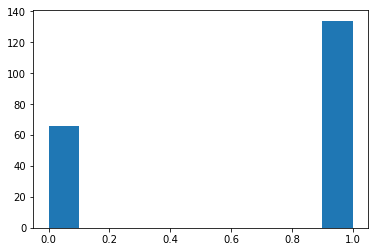

In [15]:
print(y_test.shape)
plt.hist(y_test)
plt.show()

(800,)


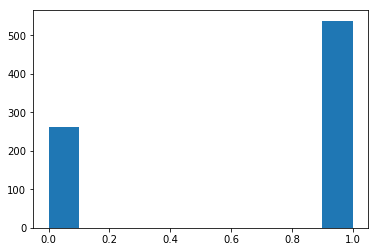

In [16]:
print(y_train.shape)
plt.hist(y_train)
plt.show()

In [17]:
Xs_train = np.reshape(Xs_train, (800,905,1))
print(Xs_train.shape)

Xs_test = np.reshape(Xs_test, (200,905,1))
print(Xs_test.shape)

(800, 905, 1)
(200, 905, 1)


In [18]:
import keras
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [19]:
import math
def step_decay(epoch, triangular = False):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

def step_decay_tri(epoch, triangular = True):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

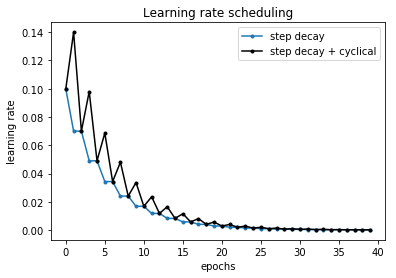

In [20]:
y = [step_decay(x) for x in range(40)]
y_tri = [step_decay(x, True) for x in range(40)]
#print(y)
plt.plot(y, '.-')
plt.plot(y_tri, '.-k')
plt.title('Learning rate scheduling')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.legend(['step decay', 'step decay + cyclical'])
plt.savefig('learning_rate.png', dpi=1000)
plt.show()

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
lstm = Sequential()

lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (905, 1)))
lstm.add(Dropout(0.3))

lstm.add(LSTM(units = 64))
lstm.add(Dropout(0.3))

lstm.add(Dense(units = 2, activation='softmax'))

lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

lstm.fit(Xs_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.15)

Instructions for updating:
Use tf.cast instead.
Train on 680 samples, validate on 120 samples
Epoch 1/10
680/680 [==============================] - 26s 39ms/step - loss: 0.6478 - acc: 0.6676 - val_loss: 0.5316 - val_acc: 0.7500
Epoch 2/10
680/680 [==============================] - 25s 36ms/step - loss: 0.6207 - acc: 0.6721 - val_loss: 0.5374 - val_acc: 0.7583
Epoch 3/10
680/680 [==============================] - 25s 37ms/step - loss: 0.6174 - acc: 0.7000 - val_loss: 0.5392 - val_acc: 0.7583
Epoch 4/10
680/680 [==============================] - 25s 37ms/step - loss: 0.6123 - acc: 0.7015 - val_loss: 0.5361 - val_acc: 0.7667
Epoch 5/10
680/680 [==============================] - 25s 37ms/step - loss: 0.6105 - acc: 0.6985 - val_loss: 0.5476 - val_acc: 0.7667
Epoch 6/10
680/680 [==============================] - 25s 37ms/step - loss: 0.6173 - acc: 0.6809 - val_loss: 0.5386 - val_acc: 0.7667
Epoch 7/10
680/680 [==============================] - 25s 37ms/step - loss: 0.6150 - acc: 0.7029 - val

In [23]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 905, 64)           16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 905, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm.evaluate(Xs_test, y_test)

200/200 [==============================] - 1s 7ms/step


[0.58300288438797, 0.73]

In [47]:
lstm.save('lstm.h5')

In [26]:
y_pred = lstm.predict_classes(Xs_test)

In [27]:
y_pred.shape

(200,)

In [28]:
y_true = y_b[test_index]

In [29]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.7298850574712644, 0.9477611940298507, 0.8246753246753246, None)

In [41]:
#  https://medium.com/@bramblexu/softmax-output-neurons-number-for-binary-classification-1e4bf91a2ffe

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

lrate = LearningRateScheduler(step_decay_tri)

bilstm = Sequential()

bilstm.add(Bidirectional(LSTM(40, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.3),
                        input_shape=(905, 1)))


bilstm.add(Bidirectional(LSTM(40, dropout = 0.2, recurrent_dropout = 0.3)))



bilstm.add(Dense(units = 2, activation='softmax'))

bilstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

bilstm.fit(Xs_train, y_train, epochs = 5, batch_size = 16, validation_split = 0.15)

Train on 680 samples, validate on 120 samples
Epoch 1/5
680/680 [==============================] - 102s 150ms/step - loss: 0.6394 - acc: 0.6765 - val_loss: 0.5434 - val_acc: 0.7583
Epoch 2/5
680/680 [==============================] - 106s 156ms/step - loss: 0.6174 - acc: 0.6809 - val_loss: 0.5510 - val_acc: 0.7667
Epoch 3/5
680/680 [==============================] - 117s 173ms/step - loss: 0.6197 - acc: 0.6779 - val_loss: 0.5308 - val_acc: 0.7500
Epoch 4/5
680/680 [==============================] - 106s 156ms/step - loss: 0.6099 - acc: 0.7059 - val_loss: 0.5378 - val_acc: 0.7500
Epoch 5/5
680/680 [==============================] - 100s 148ms/step - loss: 0.6201 - acc: 0.6824 - val_loss: 0.5441 - val_acc: 0.7500


In [35]:
bilstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 905, 80)           13440     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80)                38720     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 162       
Total params: 52,322
Trainable params: 52,322
Non-trainable params: 0
_________________________________________________________________


In [36]:
bilstm.evaluate(Xs_test, y_test)

200/200 [==============================] - 2s 12ms/step


[0.5843858551979065, 0.725]

In [37]:
y_pred = bilstm.predict_classes(Xs_test)

In [38]:
y_true = y_b[test_index]

In [48]:
bilstm.save('bilstm.h5')

In [39]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.7206703910614525, 0.9626865671641791, 0.8242811501597443, None)

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU

gru = Sequential()

gru.add(GRU(units = 64, return_sequences = True, input_shape = (905, 1)))
gru.add(Dropout(0.3))

gru.add(GRU(units = 64))
gru.add(Dropout(0.3))

gru.add(Dense(units = 2, activation='softmax'))

gru.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

gru.fit(Xs_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.15)

Train on 680 samples, validate on 120 samples
Epoch 1/10
680/680 [==============================] - 39s 57ms/step - loss: 0.6496 - acc: 0.6647 - val_loss: 0.5659 - val_acc: 0.7333
Epoch 2/10
680/680 [==============================] - 30s 44ms/step - loss: 0.6334 - acc: 0.6662 - val_loss: 0.5291 - val_acc: 0.7500
Epoch 3/10
680/680 [==============================] - 33s 48ms/step - loss: 0.6264 - acc: 0.6882 - val_loss: 0.5553 - val_acc: 0.7500
Epoch 4/10
680/680 [==============================] - 33s 49ms/step - loss: 0.6155 - acc: 0.6956 - val_loss: 0.5392 - val_acc: 0.7583
Epoch 5/10
680/680 [==============================] - 32s 48ms/step - loss: 0.6223 - acc: 0.6868 - val_loss: 0.5455 - val_acc: 0.7583
Epoch 6/10
680/680 [==============================] - 28s 41ms/step - loss: 0.6175 - acc: 0.6721 - val_loss: 0.5336 - val_acc: 0.7583
Epoch 7/10
680/680 [==============================] - 33s 48ms/step - loss: 0.6226 - acc: 0.6868 - val_loss: 0.5501 - val_acc: 0.7417
Epoch 8/10
680/6

In [45]:
gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 905, 64)           12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 905, 64)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 37,570
Trainable params: 37,570
Non-trainable params: 0
_________________________________________________________________


In [46]:
gru.save('gru.h5')

In [41]:
gru.evaluate(Xs_test, y_test)

200/200 [==============================] - 1s 7ms/step


[0.5913655662536621, 0.71]

In [42]:
y_pred = gru.predict_classes(Xs_test)

In [43]:
y_true = y_b[test_index]

In [49]:
precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.7043010752688172, 0.9776119402985075, 0.8187500000000001, None)